In [ ]:
##ONLY IF YOU DONT HAVE THE FOLLIWNG PACKAGES!!
# import sys
# !{sys.executable} -m pip install fastdtw dtw-python==1.1.7

#Or use Conda if you have conda.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer 
from datetime import datetime
from datetime import date
import re
from datetime import timedelta

%matplotlib inline

#Set path dependencies
data_path = "D:\MSDS\DS Project\Data"

# 1. Data pre-processing

Pre-processing pipeline as follows:
<ol>
    <li>Read CL 51 data</li>
        <ol>
            <li>A datetime stamp is created from data</li>
            <li>Imputation is performed on the BL height based on linear interpolation on time</li>
        </ol>
    <li>Read CTM data</li>
        <ol>
            <li>Time is converted from UTC to AEST to bring this inline with CL51 info (by adding 10 hours)</li>
            <li>Datetime stamp is similarly created</li>
        </ol>
    <li>Adjust CL 51 data format</li>
        <ol>
            <li>A "date hour" key is created</li>
        </ol>
    <li>Merge CL 51 data with CTM data based on key created above</li>
</ol>    

## 1.1 Read CL51 data

In [3]:
'''
1.1 Import CL51 data
'''
cl51_data_path = "\\CL51"

cl51_data_fn_merriwa = ['L3_DEFAULT_0_20210212_Merriwa','L3_DEFAULT_0_20210213_Merriwa',
                        'L3_DEFAULT_0_20210214_Merriwa', 'L3_DEFAULT_0_20210215_Merriwa',
                       'L3_DEFAULT_0_20210216_Merriwa','L3_DEFAULT_0_20210217_Merriwa', 
                       'L3_DEFAULT_0_20210218_Merriwa']

#Use RE
cl51_data_fn_lidcombe = [re.sub('Merriwa', 'Lidcombe',data) for data in cl51_data_fn_merriwa]

cl51_full_file_path_merriwa = [data_path+cl51_data_path+'\\'+path+'.csv' for path in cl51_data_fn_merriwa]
cl51_full_file_path_lidcombe = [data_path+cl51_data_path+'\\'+path+'.csv' for path in cl51_data_fn_lidcombe]

#Initialise a Dataframe with first table
cl51_df_merriwa = pd.read_csv(cl51_full_file_path_merriwa[0])
cl51_df_lidcombe = pd.read_csv(cl51_full_file_path_lidcombe[0])

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(cl51_full_file_path_merriwa)):
    cl51_df_merriwa = cl51_df_merriwa.append(pd.read_csv(cl51_full_file_path_merriwa[i]), ignore_index = True)
    cl51_df_lidcombe = cl51_df_lidcombe.append(pd.read_csv(cl51_full_file_path_lidcombe[i]), ignore_index = True)
    
#Set -999 values to np.nan
cl51_df_merriwa = cl51_df_merriwa.replace(-999, np.nan)
cl51_df_lidcombe = cl51_df_lidcombe.replace(-999, np.nan)

In [4]:
#Further breakdown the time stamp
#First convert to datetime object
cl51_df_merriwa['datetime'] = pd.to_datetime(cl51_df_merriwa['# Time'], format='%d/%m/%Y %H:%M:%S')
cl51_df_lidcombe['datetime'] = pd.to_datetime(cl51_df_lidcombe['# Time'], format='%d/%m/%Y %H:%M:%S')


In [5]:
'''
Imputation

Strategy: Use df.interpolate method = time
'''
#Reset index
cl51_df_merriwa = cl51_df_merriwa.set_index('datetime')
cl51_df_lidcombe = cl51_df_lidcombe.set_index('datetime')

#Define a new column
cl51_df_merriwa = cl51_df_merriwa.assign(revised_bl_height=cl51_df_merriwa.bl_height.interpolate(method='time'))
cl51_df_lidcombe = cl51_df_lidcombe.assign(revised_bl_height=cl51_df_lidcombe.bl_height.interpolate(method='time'))


In [5]:
#Sanity check 2
cl51_df_merriwa

,# Time,Layer_QualityIndex,bl_height,Mean_Layer_Height,n_BL,cloud_stat,cloud_dat,revised_bl_height
datetime,,,,,,,,
2021-02-12 11:00:00,12/02/2021 11:00:00,NaN,2090.0,NaN,3,1,8430.0,2090.0
2021-02-12 11:00:32,12/02/2021 11:00:32,NaN,1430.0,NaN,3,1,8430.0,1430.0
2021-02-12 11:00:48,12/02/2021 11:00:48,NaN,1410.0,NaN,3,1,8430.0,1410.0
2021-02-12 11:01:04,12/02/2021 11:01:04,NaN,1380.0,NaN,3,1,8430.0,1380.0
2021-02-12 11:01:20,12/02/2021 11:01:20,NaN,1400.0,NaN,3,1,8400.0,1400.0
...,...,...,...,...,...,...,...,...
2021-02-19 10:58:40,19/02/2021 10:58:40,2.0,NaN,270.0,3,1,1940.0,500.0
2021-02-19 10:58:56,19/02/2021 10:58:56,2.0,NaN,270.0,3,3,640.0,500.0
2021-02-19 10:59:12,19/02/2021 10:59:12,2.0,NaN,270.0,3,3,640.0,500.0


In [6]:
cl51_df_lidcombe

,# Time,Layer_QualityIndex,bl_height,Mean_Layer_Height,n_BL,cloud_stat,cloud_dat,revised_bl_height
datetime,,,,,,,,
2021-02-12 11:00:00,12/02/2021 11:00:00,3.0,440.0,390.0,3,1,4880.0,440.0
2021-02-12 11:00:16,12/02/2021 11:00:16,3.0,440.0,390.0,3,1,4850.0,440.0
2021-02-12 11:00:32,12/02/2021 11:00:32,3.0,440.0,390.0,3,1,4850.0,440.0
2021-02-12 11:00:48,12/02/2021 11:00:48,3.0,440.0,390.0,3,1,4600.0,440.0
2021-02-12 11:01:04,12/02/2021 11:01:04,3.0,440.0,390.0,3,1,4600.0,440.0
...,...,...,...,...,...,...,...,...
2021-02-19 10:58:40,19/02/2021 10:58:40,1.0,890.0,930.0,3,1,750.0,890.0
2021-02-19 10:58:56,19/02/2021 10:58:56,1.0,890.0,930.0,3,1,750.0,890.0
2021-02-19 10:59:12,19/02/2021 10:59:12,1.0,890.0,930.0,3,1,760.0,890.0


Text(0.5, 0, 'Date')

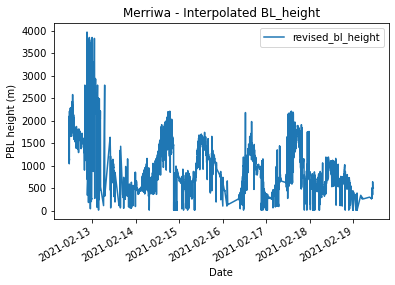

In [5]:
#Raw visualisation

cl51_df_merriwa.plot(y = ['revised_bl_height'])
plt.title('Merriwa - Interpolated BL_height')
plt.ylabel('PBL height (m)')
plt.xlabel('Date')



Text(0.5, 0, 'Date')

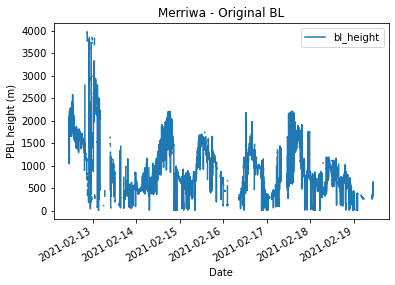

In [8]:

cl51_df_merriwa.plot(y = ['bl_height'])
plt.title('Merriwa - Original BL')
plt.ylabel('PBL height (m)')
plt.xlabel('Date')


Text(0.5, 0, 'Date')

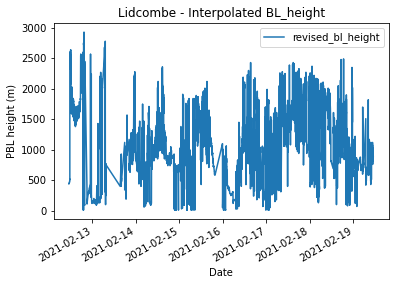

In [9]:
cl51_df_lidcombe.plot(y = ['revised_bl_height'])
plt.title('Lidcombe - Interpolated BL_height')
plt.ylabel('PBL height (m)')
plt.xlabel('Date')



Text(0.5, 0, 'Date')

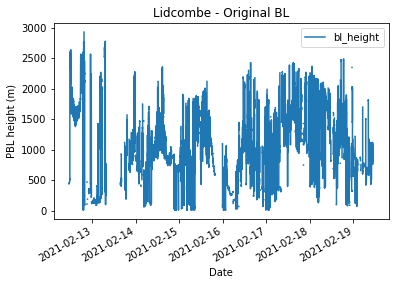

In [10]:

cl51_df_lidcombe.plot(y = ['bl_height'])
plt.title('Lidcombe - Original BL')
plt.ylabel('PBL height (m)')
plt.xlabel('Date')


Imputation looks reasonable..

## 1.2.1 Read CTM data

In [6]:
'''
2. Import CTM data
'''
ctm_data_path = "\\CTM OUTPUT"

ctm_data_fn_merriwa = ['ctm_gmr_20210212_Merriwa','ctm_gmr_20210213_Merriwa',
                       'ctm_gmr_20210214_Merriwa','ctm_gmr_20210215_Merriwa',
                       'ctm_gmr_20210216_Merriwa','ctm_gmr_20210217_Merriwa',
                       'ctm_gmr_20210218_Merriwa']

#Use RE
ctm_data_fn_lidcombe = [re.sub('Merriwa', 'Lidcombe',data) for data in ctm_data_fn_merriwa]

ctm_full_file_path_merriwa = [data_path+ctm_data_path+'\\'+path+'.csv' for path in ctm_data_fn_merriwa]
ctm_full_file_path_lidcombe = [data_path+ctm_data_path+'\\'+path+'.csv' for path in ctm_data_fn_lidcombe]

#Initialise a Dataframe with first table
ctm_df_merriwa = pd.read_csv(ctm_full_file_path_merriwa[0])
ctm_df_lidcombe = pd.read_csv(ctm_full_file_path_lidcombe[0])

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(ctm_full_file_path_merriwa)):
    ctm_df_merriwa = ctm_df_merriwa.append(pd.read_csv(ctm_full_file_path_merriwa[i]), ignore_index = True)
    ctm_df_lidcombe = ctm_df_lidcombe.append(pd.read_csv(ctm_full_file_path_lidcombe[i]), ignore_index = True)

In [7]:
#Esoteric spaces...
ctm_df_merriwa.keys()

Index(['lat', ' lon', ' date', ' time', ' temperature', ' mixing_height'], dtype='object')

In [8]:
'''
Change time to AEST and set datetime
'''

def convert_df_to_datetime(df):
    df['time_AEST'] = (df[' time'] + 10) % 24

    #Loop through and convert date to proper date
    length_data = len(df)

    #Defined new columns
    df['date_proper'] = 0
    df['datetime'] = ''

    #Sets the date based on change of time and creates a datetime stamp
    #Very clunky but it works
    for i in range(length_data):
        date_1 = str(df.loc[i,' date'])

        year_date_1 = date_1[:4]
        month_date_1 = date_1[4:6]
        day_date_1 = int(date_1[6::])

        if i > 1:
            #This means the day has changed
            if (df.loc[i,'time_AEST'] < df.loc[i-1,'time_AEST']):
                day_date_1 += 1

        df.loc[i, 'date_proper'] = date(int(year_date_1), int(month_date_1), day_date_1)

        #Days are monotonic
        if i > 1:
            if (df.loc[i,'date_proper'] < df.loc[i-1,'date_proper']):
                df.loc[i,'date_proper'] = df.loc[i-1,'date_proper']

        date_proper_1 = str(df.loc[i,'date_proper'])
        time_1 = str(df.loc[i, 'time_AEST'])

        datetime_str = date_proper_1 + " " + time_1
        df.loc[i, 'datetime'] = datetime.strptime(datetime_str, '%Y-%m-%d %H')

    #Set index to datetime
    df = df.set_index('datetime')
    
    return df

In [9]:
#Apply functions
ctm_df_merriwa = convert_df_to_datetime(ctm_df_merriwa)
ctm_df_lidcombe = convert_df_to_datetime(ctm_df_lidcombe)

In [9]:
#sanity check
ctm_df_merriwa

,lat,lon,date,time,temperature,mixing_height,time_AEST,date_proper
datetime,,,,,,,,
2021-02-12 10:00:00,-32.14,150.5,20210212,0,29.91,1460.2307,10,2021-02-12
2021-02-12 11:00:00,-32.14,150.5,20210212,1,32.01,2116.5154,11,2021-02-12
2021-02-12 12:00:00,-32.14,150.5,20210212,2,33.03,2268.4509,12,2021-02-12
2021-02-12 13:00:00,-32.14,150.5,20210212,3,33.56,2332.6211,13,2021-02-12
2021-02-12 14:00:00,-32.14,150.5,20210212,4,33.70,2376.4629,14,2021-02-12
...,...,...,...,...,...,...,...,...
2021-02-19 05:00:00,-32.14,150.5,20210218,19,18.19,156.5146,5,2021-02-19
2021-02-19 06:00:00,-32.14,150.5,20210218,20,18.99,271.2063,6,2021-02-19
2021-02-19 07:00:00,-32.14,150.5,20210218,21,20.34,402.5884,7,2021-02-19


In [29]:
ctm_df_lidcombe

,lat,lon,date,time,temperature,mixing_height,time_AEST,date_proper
datetime,,,,,,,,
2021-02-12 10:00:00,-33.9,151.06,20210212,0,31.63,898.0856,10,2021-02-12
2021-02-12 11:00:00,-33.9,151.06,20210212,1,33.49,1035.7593,11,2021-02-12
2021-02-12 12:00:00,-33.9,151.06,20210212,2,34.07,984.8432,12,2021-02-12
2021-02-12 13:00:00,-33.9,151.06,20210212,3,33.34,546.3094,13,2021-02-12
2021-02-12 14:00:00,-33.9,151.06,20210212,4,31.39,559.0942,14,2021-02-12
...,...,...,...,...,...,...,...,...
2021-02-19 05:00:00,-33.9,151.06,20210218,19,22.63,152.9865,5,2021-02-19
2021-02-19 06:00:00,-33.9,151.06,20210218,20,22.91,335.2351,6,2021-02-19
2021-02-19 07:00:00,-33.9,151.06,20210218,21,23.15,417.5187,7,2021-02-19


## 1.2.2 Read WRF data

In [10]:
def convert_df_to_datetime_wrf(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H:%M:%S')+ timedelta(hours=10)
    
    #Set index to datetime
    df = df.set_index('datetime')
    
    #Keep the last index
    #As per Hiep response - 24/8/2021 - we keep last value

    df = df[~df.index.duplicated(keep = 'last')]

    return df

In [11]:
'''
2. Import WRF data
'''
wrf_data_path = "\\WRF"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218', 'PBLH_series329_20210219']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})
    

wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)

In [11]:
wrf_df_merriwa.head()

,WRF PBLH
datetime,
2021-02-11 22:00:00,0.00
2021-02-11 23:00:00,32.77
2021-02-12 00:00:00,32.73
2021-02-12 01:00:00,32.65
2021-02-12 02:00:00,250.01


In [12]:
#sanity check
wrf_df_lidcombe.head()

,WRF PBLH
datetime,
2021-02-11 22:00:00,0.00
2021-02-11 23:00:00,421.60
2021-02-12 00:00:00,420.69
2021-02-12 01:00:00,419.69
2021-02-12 02:00:00,32.83


## 1.3. Smash CL51 data in format that we can compare

In [12]:
'''
Function: convert CL51 data to grouped data
'''
def cl51_data_grouped(df):
    #Unset datetime index
    cl51_df_v2 = df.reset_index()
    
    #Create unique datetime key with hourly granularity
    cl51_df_v2['key'] = cl51_df_v2['datetime'].dt.year.astype(str)+cl51_df_v2['datetime'].dt.month.astype(str)+cl51_df_v2['datetime'].dt.day.astype(str)+cl51_df_v2['datetime'].dt.hour.astype(str)

    #Group PBLH on key 
    cl51_grouped_df = pd.DataFrame(cl51_df_v2.groupby(cl51_df_v2["key"])["revised_bl_height"].mean())
    
    cl51_grouped_df = cl51_grouped_df.reset_index()
    
    return cl51_grouped_df

In [15]:
cl51_grouped_df_merriwa = cl51_data_grouped(cl51_df_merriwa)
cl51_grouped_df_lidcombe = cl51_data_grouped(cl51_df_lidcombe)

## 1.4. Smash both data into one database

In [13]:
'''
Function: Combines CL51, CTM and WRF data to one consolidated output
'''
def combined_data(cl51_grouped_df, ctm_df, wrf_df):
    #Use CTM data as base - as this has smaller number of rows
    df = pd.DataFrame(ctm_df.loc[:,' mixing_height'])

    #unset datetime index
    df = df.reset_index()

    #Create key similar to CL51 groupped data
    df['key'] = df['datetime'].dt.year.astype(str)+df['datetime'].dt.month.astype(str)+df['datetime'].dt.day.astype(str)+df['datetime'].dt.hour.astype(str)

    #Create a deep copy inside
    wrf_df = wrf_df.copy(deep = True)
    
    #Set keys similar to above
    wrf_df = wrf_df.reset_index()
    wrf_df['key'] = wrf_df['datetime'].dt.year.astype(str)+wrf_df['datetime'].dt.month.astype(str)+wrf_df['datetime'].dt.day.astype(str)+wrf_df['datetime'].dt.hour.astype(str)    
    
    #Merge with CL51
    df_2 = pd.merge(df, cl51_grouped_df, how = 'inner', on = 'key')
    
    #Merge with wrf
    df_3 = pd.merge(df_2, wrf_df, how = 'inner', on = 'key').rename(columns = {'datetime_x':'datetime'}).set_index('datetime')
        
    #Drop unnecessary stuff
#     df_3 = df_3.drop(columns = ['key', 'datetime_y', 'date', 'time', 'time_AEST', 'date_proper'])
    
    #rename columns
    df_3 = df_3.rename(columns = {' mixing_height':'CTM Predicted PBLH', 'revised_bl_height':'Actual PBLH', 'WRF PBLH':'WRF Predicted PBLH'})
    
    cols = ['Actual PBLH', 'CTM Predicted PBLH', 'WRF Predicted PBLH']
    
    df_3 = df_3[cols]
    
    return df_3 

In [16]:
comp_df_merriwa = combined_data(cl51_grouped_df_merriwa, ctm_df_merriwa, wrf_df_merriwa)
comp_df_lidcombe = combined_data(cl51_grouped_df_lidcombe, ctm_df_lidcombe, wrf_df_lidcombe)

In [17]:
#sanity check
comp_df_merriwa

,Actual PBLH,CTM Predicted PBLH,WRF Predicted PBLH
datetime,,,
2021-02-12 11:00:00,1782.971698,2116.5154,918.04
2021-02-12 12:00:00,2060.904255,2268.4509,1629.29
2021-02-12 13:00:00,1942.894737,2332.6211,2124.96
2021-02-12 14:00:00,1684.731183,2376.4629,2726.00
2021-02-12 15:00:00,1573.967391,2432.8503,2727.78
...,...,...,...
2021-02-19 05:00:00,264.802803,156.5146,247.39
2021-02-19 06:00:00,271.336676,271.2063,247.39
2021-02-19 07:00:00,283.446311,402.5884,416.71


In [18]:
comp_df_lidcombe

,Actual PBLH,CTM Predicted PBLH,WRF Predicted PBLH
datetime,,,
2021-02-12 11:00:00,1474.222222,1035.7593,1669.35
2021-02-12 12:00:00,1826.222222,984.8432,1674.54
2021-02-12 13:00:00,1662.444444,546.3094,2194.04
2021-02-12 14:00:00,1500.755556,559.0942,1682.49
2021-02-12 15:00:00,1546.844444,330.0530,2199.28
...,...,...,...
2021-02-19 05:00:00,845.268328,152.9865,338.62
2021-02-19 06:00:00,1094.350000,335.2351,253.00
2021-02-19 07:00:00,616.111111,417.5187,425.39


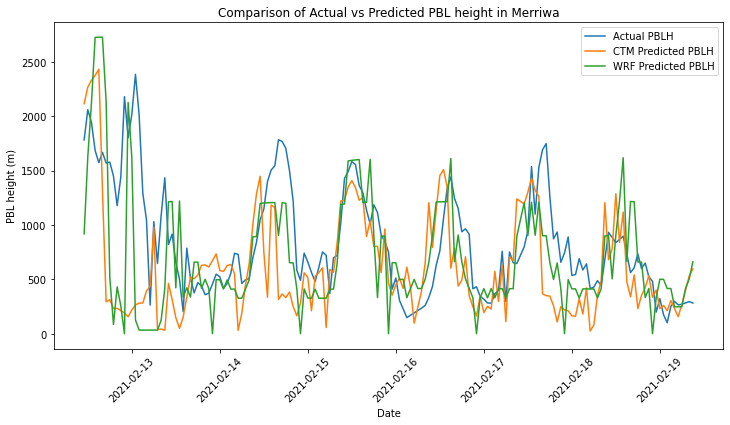

In [18]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 6))

# Add x-axis and y-axis
ax.plot(comp_df_merriwa)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="PBL height (m)",
       title="Comparison of Actual vs Predicted PBL height in Merriwa")

ax.legend(comp_df_merriwa)

plt.xticks(rotation=45)

plt.show()

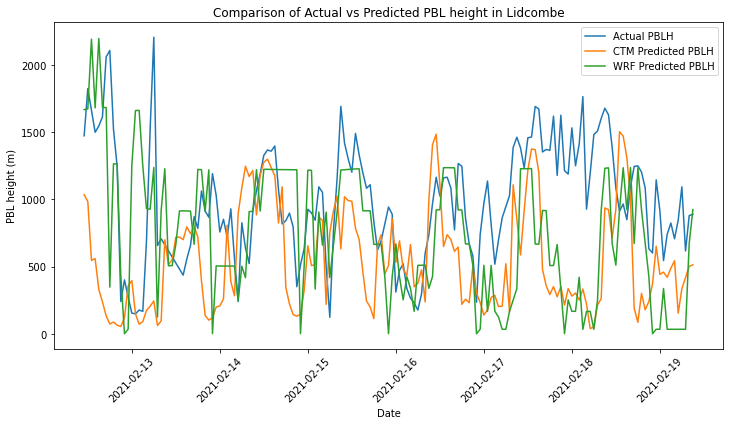

In [19]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 6))

# Add x-axis and y-axis
ax.plot(comp_df_lidcombe)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="PBL height (m)",
       title="Comparison of Actual vs Predicted PBL height in Lidcombe")

ax.legend(comp_df_lidcombe)

plt.xticks(rotation=45)

plt.show()

Merriwa is quite nicely correlated. Lidcombe not so. Particularly from 17/2 - 18/2. What's going on?

General observations:

* The PBL height exhibits a peak and trough type behaviour where peaks are typically around midday and troughs are late at night/early mornings. 
* Overall fairly reasonable correlation between the predicted and actual PBL over the one week period. The CT model was able to capture the behaviour of the PBL height in both locations. 

Observations:
* There are siginificant deviations in the quality of the predicted PBL height from the CT model as compared to the actual PBL heights from the CL51 ceilometer in both locations.
* In particular, we note that in Merriwa the CT model outputs tend to match the actual PBL height much more closely than in Lidcombe.
* While we offer no concrete reasons as to why this is the case, we reason that this may be driven in large part by the location of the two sets of observations. Merriwa is located in the Hunter Valley where there is little disturbances from urban infrastructure (i.e. cars, heat emited by humans) whereas Lidcombe is an inner suburb within the Sydney Metropolitan area.
* In Merriwa:
    * Quite a tight overlap between predicted and actual PBL height over the one week period. 
    * Observations in 12/2/2021 13/2/2021 are however off. This is due to poor quality readings from CL51 which may be as a result of rain during this period. 
    * From midday 13/2/2021 to around midday 17/2/2021 the CT model was in agreement with the actual observed PBL height.
    * There is then another large discrepancy in readings from midday 17/2/2021 to 18/2/2021. Unsure as to why this is the case
    
* In Lidcombe:
    * The CT model and CL51 readings exhibit siginifcant deviations in this location.
    * We observe that while there is some agreement as to the timing of the peaks and troughs of the PBL height as measured by the CT model and the CL51 ceilometer, their magnitudes are vastly different for instance the actual vs predicted PBL heights at 12/2/2021.
    * In some instances i.e. during 17/2/2021 to 18/2/2021, the predicted vs actual PBL height are in total opposite to one another. 
    * It is unclear from our analysis as to what may be the cause of this.


    

In [22]:
'''
Function that plots by hour and date
'''
def plot_by_hour_date(df, attribute, title):
    copy1 = df.copy(deep = True)
    copy1 = copy1.reset_index()
    copy1['hour'] = copy1['datetime'].dt.hour
    copy1['date'] = copy1['datetime'].dt.date

    fig, ax = plt.subplots(figsize=(15,7))
    # use unstack()
    copy1.groupby(['hour','date']).sum()[attribute].unstack().plot(ax=ax)
    plt.title(title)
    plt.ylim([0,2500])
    plt.xlabel('Hour of day')
    plt.ylabel('PBL height (m)')

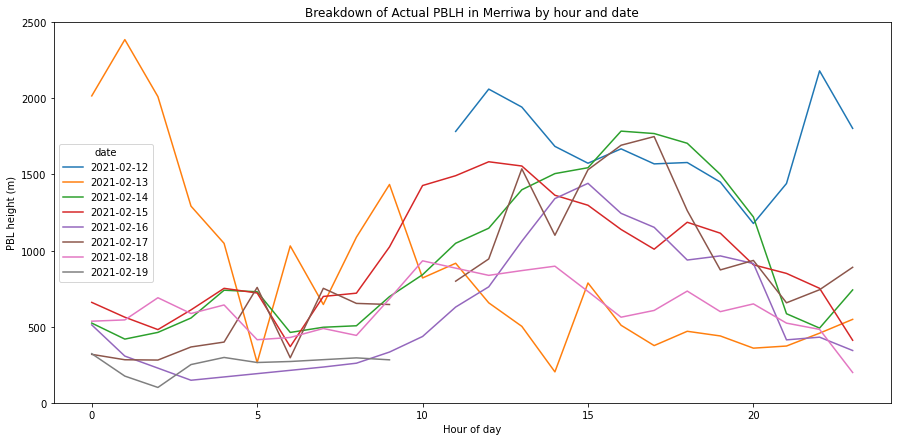

In [23]:
plot_by_hour_date(comp_df_merriwa, 'Actual PBLH', 'Breakdown of Actual PBLH in Merriwa by hour and date')

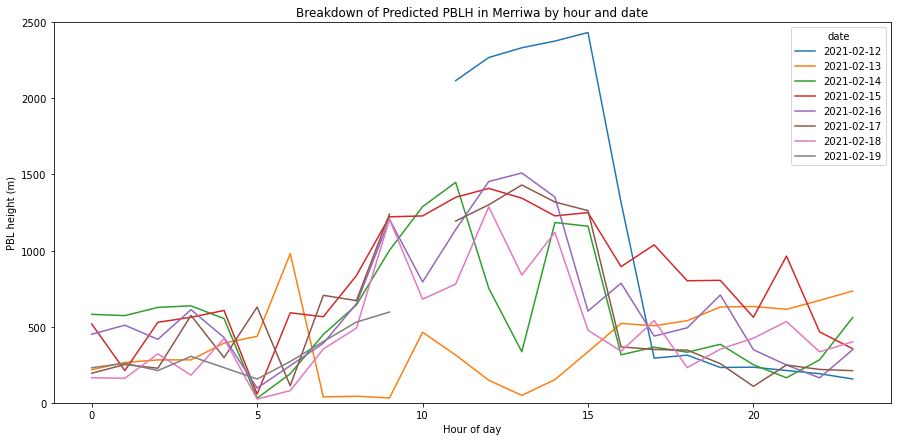

In [27]:
plot_by_hour_date(comp_df_merriwa, 'Predicted PBLH', 'Breakdown of Predicted PBLH in Merriwa by hour and date')

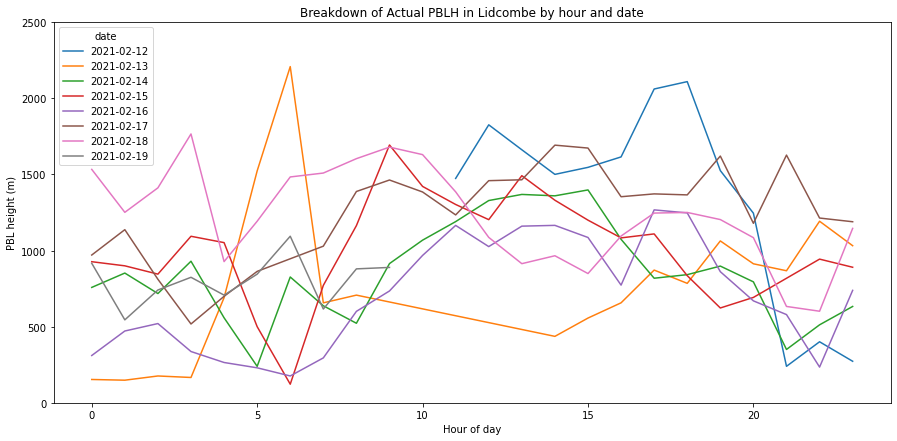

In [28]:
plot_by_hour_date(comp_df_lidcombe, 'Actual PBLH', 'Breakdown of Actual PBLH in Lidcombe by hour and date')

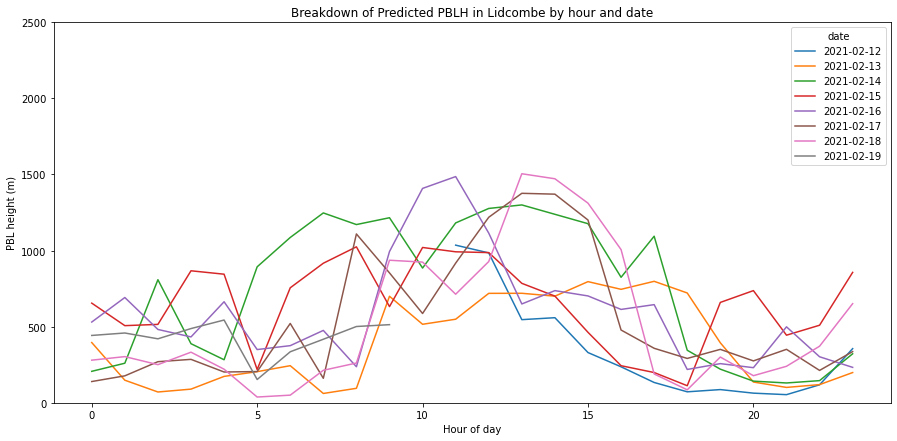

In [29]:
plot_by_hour_date(comp_df_lidcombe, 'Predicted PBLH', 'Breakdown of Predicted PBLH in Lidcombe by hour and date')

### Does layer quality matter?

Investigate only with non np.nan layers

In [30]:
cl51_df_merriwa.keys()

Index(['# Time', ' Layer_QualityIndex', 'bl_height', 'Mean_Layer_Height',
       'n_BL', 'cloud_stat', 'cloud_dat', 'revised_bl_height'],
      dtype='object')

In [31]:
#Drop layer quality that is na
cl51_df_merriwa_non_npnan = cl51_df_merriwa[cl51_df_merriwa[' Layer_QualityIndex'].notna()]
cl51_df_lidcombe_non_npnan = cl51_df_lidcombe[cl51_df_lidcombe[' Layer_QualityIndex'].notna()]

In [32]:
#Group data and smash
#Merriwa
cl51_df_merriwa_non_npnan_grouped = cl51_data_grouped(cl51_df_merriwa_non_npnan)
comp_df_merriwa_non_npnan = combined_data(cl51_df_merriwa_non_npnan_grouped, ctm_df_merriwa)

#Lidcombe
cl51_df_lidcombe_non_npnan_grouped = cl51_data_grouped(cl51_df_lidcombe_non_npnan)
comp_df_lidcombe_non_npnan = combined_data(cl51_df_lidcombe_non_npnan_grouped, ctm_df_lidcombe)


<AxesSubplot:xlabel='datetime'>

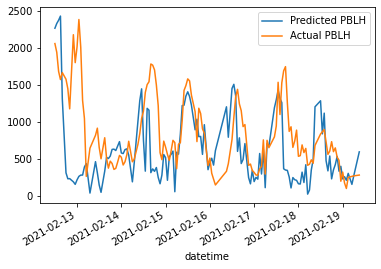

In [33]:
#Plot
comp_df_merriwa_non_npnan.plot()

<AxesSubplot:xlabel='datetime'>

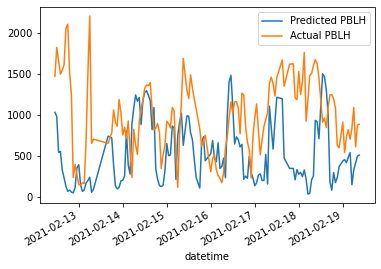

In [34]:
comp_df_lidcombe_non_npnan.plot()

Not much difference. Inclined to use full imputed data

# 2. Statistical comparisons

Comparing against what? What is a benchmark metric for say rmse?

In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [21]:
'''
Source: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

This basically looks like a modified version of R2?
'''

def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [22]:
'''
Calculate mean bias error
'''
def mean_bias_error(df, pred_name):
    y_true = df.loc[:,'Actual PBLH'].values
    y_pred = df.loc[:,pred_name].values

    return np.mean(y_pred - y_true)


In [23]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(df, pred_name):
    y_true = df.loc[:,'Actual PBLH'].values
    y_pred = df.loc[:,pred_name].values

    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

In [24]:
'''
Function: Calculates and prints out the varoius metrics
'''

def satistical_comps_on_df(df, pred_name, location):    
    y_true = df.loc[:,'Actual PBLH'].values
    y_pred = df.loc[:,pred_name].values
    
    #ioa = cohen_kappa_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(df, pred_name)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(df, pred_name)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f' % (location, ioa, rmse, mae, mbe, dtw_dist))

In [25]:
satistical_comps_on_df(comp_df_merriwa,'CTM Predicted PBLH', 'Merriwa - actual vs CTM model')

At Merriwa - actual vs CTM model
Index of agreement:0.64061
Root mean squared error:597.29548
Mean absoluate error:415.92010
Mean bias error:-232.90500
DTW distance:91525.88


In [26]:
satistical_comps_on_df(comp_df_merriwa,'WRF Predicted PBLH', 'Merriwa - actual vs WRF model')

At Merriwa - actual vs WRF model
Index of agreement:0.72481
Root mean squared error:525.53093
Mean absoluate error:362.98578
Mean bias error:-143.99173
DTW distance:69894.23


In [27]:
satistical_comps_on_df(comp_df_lidcombe, 'CTM Predicted PBLH', 'Lidcombe - actual vs CTM model')

At Lidcombe - actual vs CTM model
Index of agreement:0.47060
Root mean squared error:684.40913
Mean absoluate error:540.42992
Mean bias error:-429.58751
DTW distance:107124.36


In [28]:
satistical_comps_on_df(comp_df_lidcombe, 'WRF Predicted PBLH', 'Lidcombe - actual vs WRF model')

At Lidcombe - actual vs WRF model
Index of agreement:0.57116
Root mean squared error:597.38813
Mean absoluate error:453.29674
Mean bias error:-243.82278
DTW distance:68825.18


#### Observations

Information CL51 readings vs CTM readings in Merriwa is more tightly correlated compared to Lidcombe. This is confirmed by both visual and inspections and the statistical values 

In [42]:
distance_merriwa, _ = DTW_dist(comp_df_merriwa)
distance_lidcombe, _ = DTW_dist(comp_df_lidcombe)

print(distance_merriwa, distance_lidcombe)

91525.87847283664 107124.3568849109


In [43]:
from dtw import *

def dtw_functions(df):

    y_true = df.loc[:,'Actual PBLH'].values
    y_pred = df.loc[:,'Predicted PBLH'].values
    #Stolen from website
    alignment = dtw(y_true, y_pred, keep_internals=True)

    ## Display the warping curve, i.e. the alignment curve
    alignment.plot(type="threeway")
    
    
    ## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
    dtw(y_true, y_pred, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c")).plot(type="twoway")
    
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    print('DTW distance:%.2f'%(distance))
    

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



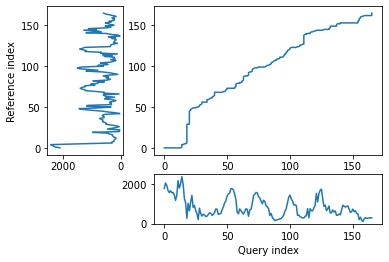

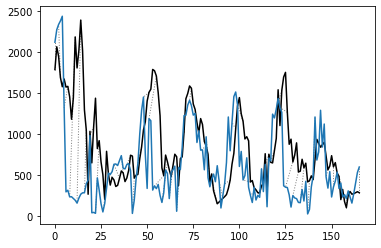

DTW distance:91525.88


In [44]:
dtw_functions(comp_df_merriwa)

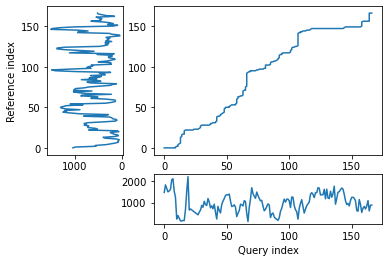

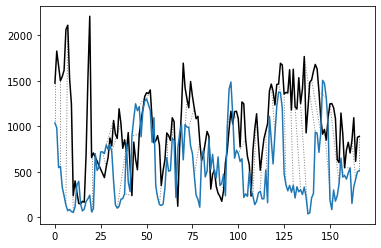

DTW distance:107124.36


In [45]:
dtw_functions(comp_df_lidcombe)

Cool. What does this mean?